# 2 практическое задание. Сегментация изображений.

## Практикум на ЭВМ для 317 группы, весна 2019

#### Фамилия, имя: 

Дата выдачи: 21 марта

Мягкий дедлайн: 2 апреля 06:00 

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур Unet и Linknet.

## Загрузка данных (1 балл)

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с imagenet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс PhotosDataset для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [1]:
import torch
import torch.nn as nn

import numpy as np
import numpy.testing as npt

In [2]:
from torch.utils.data.dataset import Dataset
from PIL import Image
import os
from glob import glob

class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        images_names : list of str
            Images short names
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        # your code here
        self.images_dir = images_dir
        self.target_dir = target_dir
        
        self.images = glob(os.path.join(images_dir, '*'))
        self.masks = glob(os.path.join(target_dir, '*'))
        
        self.transforms = transforms
        
        
    def __len__(self):
        # your code here
        return len(self.images)
                   
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask
        
        Returns
        -------
        (image, mask)
        """
        # your code here
        
        image, mask = (Image.open(self.images[idx]), Image.open(self.masks[idx]))
        if self.transforms is not None:
            for transform in self.transforms:
                image, mask = transform(image, mask)
            
        return image, mask

In [3]:
data = PhotosDataset('train/', 'train_mask/')

In [4]:
len(data)

1350

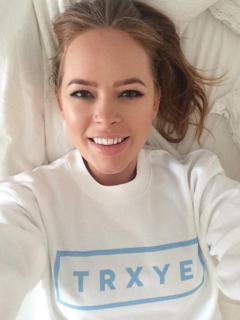

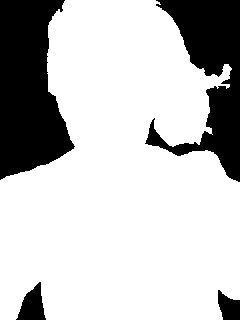

In [5]:
display(data[0][0], data[0][1])

## Модуль аугментации (3 балла)

Конструктор стандартного `ImageFolder`, принимают параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в http://pytorch.org/docs/master/torchvision/transforms.html.

В данной части вам предлагается самостояльно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

* случайное (с вероятностью p) горизонтальное отображение (flip) изображения 
* случайное (с веротностью p) вырезание фрагмента изображения (заданного или случайного размера)
* случайное (с вероятностью p) изменение яркости изображения (на заданную или случайную величину)
* случайное (с веротностью p) изменение фона изображения (на изображение из заданного списка изображений)

In [6]:
from scipy import stats

In [7]:
bg_list = [Image.open(name) for name in glob(os.path.join('bg_data/', '*'))]

In [8]:
# your code here
from PIL import ImageEnhance, ImageOps
import random as random


Randomize = lambda tr, p: lambda pair: tr(pair) if np.random.rand() < p else pair

def Randomize(p):
    def Randomize_no_args(f):
        def res(image, mask):
            if np.random.rand() < p:
                return f(image, mask)
            return image, mask
        return res
    return Randomize_no_args

def HorizontalFlip(img, mask):
    return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT)
    
def Crop(img, mask):
    ratio = np.random.uniform(0.5, 1.0)
    size = (int(ratio * img.size[0]), int(ratio * img.size[1]))
    pos = (np.random.randint(img.size[0]-size[0]), np.random.randint(img.size[1]-size[1]))
    region = pos + (pos[0] + size[0], pos[1] + size[1])

    return img.crop(region).resize(img.size), mask.crop(region).resize(mask.size)
    
def BrightnessChange(img, mask, dist=stats.norm()):
    return ImageEnhance.Brightness(img).enhance(abs(dist.rvs() + 1)), mask
    
def BackgroundChange(img, mask, bg_list=bg_list):
    result = img.copy()
    img_bg = random.choice(bg_list)

    scale = min(img_bg.height/result.height, img_bg.width/result.width)
    size = (result.size[0] * scale, result.size[1] * scale)
    region = ((img_bg.width - size[1])/2, (img_bg.height - size[0])/2, (img_bg.width + size[1])/2, (img_bg.height + size[0])/2)
    img_bg = img_bg.crop(region)
    result.paste(img_bg.resize(result.size), mask=ImageOps.invert(mask))
    return result, mask

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```
transforms.ToTensor()
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
```

In [9]:
import torch as tc
import torchvision as tv

In [10]:
ToTensor = lambda: lambda img, mask: (tv.transforms.ToTensor()(img), tv.transforms.ToTensor()(mask))
Normalize = lambda: lambda img, mask: (tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img), mask)

DATA_PATH = ''

train_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train/'),
    target_dir=os.path.join(DATA_PATH, 'train_mask/'),
    transforms=[
        Randomize(0.5)(HorizontalFlip),
        Randomize(0.8)(BrightnessChange),
        Randomize(0.8)(BackgroundChange),
        Randomize(0.8)(Crop),

        ToTensor(),
        Normalize()
    ]
)

test_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'test/'),
    target_dir=os.path.join(DATA_PATH, 'test_mask/'),
    transforms=[
        ToTensor(),
        Normalize()
    ]
)

Функция для отображения изображения:

In [11]:
import matplotlib.pyplot as plt

In [12]:
def show_idx_image(dataset, idx):
    mask_img = dataset[idx]

    image_to_show = mask_img[0].transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)

    mask_to_show = mask_img[1][0].numpy()
    
    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(14)
    fig.set_figheight(6)


    plt.subplot(1, 2, 1)
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_to_show, 'gray')
    plt.axis('off')

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.

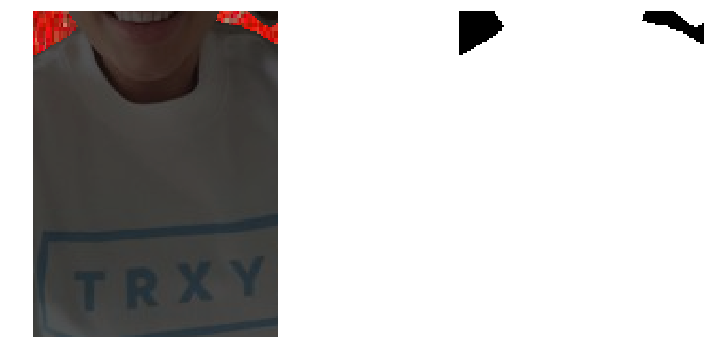

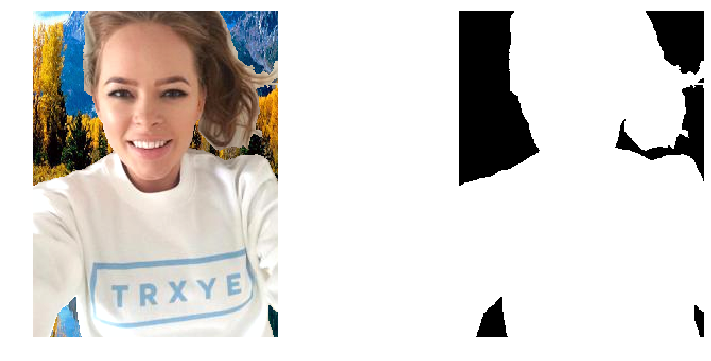

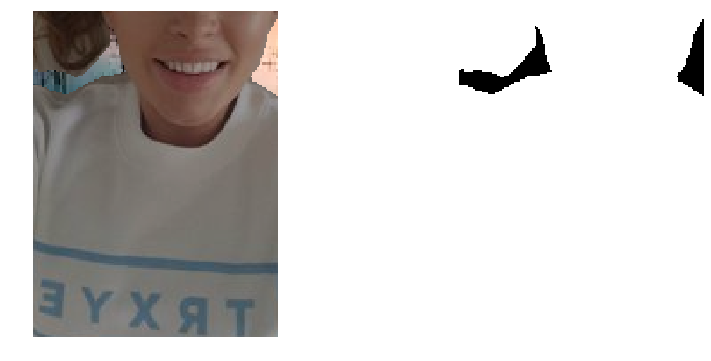

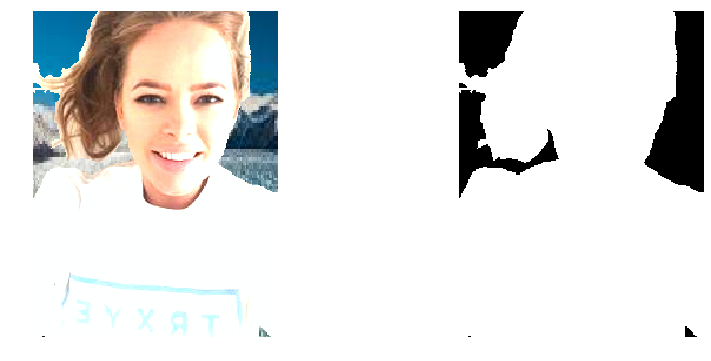

In [13]:
# your code here
show_idx_image(train_dataset, 0)
show_idx_image(train_dataset, 0)
show_idx_image(train_dataset, 0)
show_idx_image(train_dataset, 0)

## Загрузчики

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры DataLoader. При num_workers > 1, батчи готовятся (загружаются картинки, обрабатываются и т.д.) сразу в нескольких фоновых процессах. С помощью параметра shuffle можно подавать картинки на обучение в случайном порядке.

In [14]:
from torch.utils.data.dataloader import DataLoader

In [17]:
train_data_loader = DataLoader(train_dataset, batch_size=15, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=15)

## DiceLoss (1 балл)

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через nn.Module. В ячейке ниже вам предлагается реализовать фукцию потерь dice (аналог меры Джаккарда).

Результат dice loss определим как:

$$
1 - \frac{2\sum_{i, j}a_{ij}b_{ij}}{\sum_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — разметка для пикселя изображения.

In [18]:
from torch import nn

In [19]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7, reduction='none', with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : string ('none', 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            'none': no reduction will be applied
            'mean': the sum of the output will be divided by the number of batches in the output
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        true_labels = true_labels.float()
        
        if self.with_logits:
            logits = torch.sigmoid(logits)
        
        loss_value = 1 - 2 * (logits*true_labels).sum((1, 2)) / (logits + true_labels + self.eps).sum((1, 2))
        
        if self.reduction == 'sum':
            loss_value = loss_value.sum() 
        elif self.reduction == 'mean':
            loss_value = loss_value.mean()
        elif self.reduction == 'none':
            pass
            
        return loss_value

Проверка реализации:

In [20]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## Unet (2 балла)

Для решения задачи сегментации будем использовать UNet с энкодером из первых блоков предобученного VGG13. Архитектура сети реализована за вас ниже.

Энкодер:

In [21]:
from torchvision.models.vgg import vgg13

In [22]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        feature_extractor = vgg13(pretrained=pretrained).features
        for i in range(self.num_blocks):
            self.blocks.append(
                torch.nn.Sequential(*[feature_extractor[j]
                                      for j in range(i * 5, i * 5 + 4)]))

    def forward(self, x):
        activations = []
        for i in range(self.num_blocks):
            x = self.blocks[i](x)
            activations.append(x)
            if i != self.num_blocks - 1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
        return activations

Декодер:

In [23]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )

    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.conv1(torch.cat([left, x], 1))
        x = self.conv2(x)
        return x
    


In [24]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up
    
class DecoderLinkNet(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlockLinkNet(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

Сеть Unet:

In [25]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x
    
class LinkNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = DecoderLinkNet(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

Функция для оценивания качества сети:

In [26]:
def evaluate_net(net, testloader, criterion, val_criterion, device='cpu'):
    net = net.eval()

    loss = 0.
    correct = 0.
    total = 0.
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            images = images.to(device)
            
            outputs = net(images).to('cpu')
            total += labels.size(0)
            loss += float(criterion(outputs, labels).detach())
            correct += float(val_criterion(outputs, labels).detach())
    
    mean_loss = loss / total
    metric = correct / total
    
    return mean_loss, metric

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке.

Сначала при обучении используйте только кросс-энтропию (torch.nn.BCEWithLogitsLoss будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации (только кросс-энтропия, только dice loss, сумма двух лоссов с весами). Сделайте выводы.

In [28]:
# your code here

def optimize_net(n_epochs, net, optimizer, criterion, val_criterion,
                 trainloader, testloader,
                 use_cuda=True):
    net = net.train()
    
    history = {
        'train_loss': [],
        'test_verbose_steps': [],
        'test_loss': [],
        'test_accuracy': [],
    }
    
    # loop over the dataset multiple times
    for epoch in range(n_epochs):  
        running_loss = 0.0
        total_objects = 0
        
        for data in trainloader:
            # get the inputs
            inputs, labels = data
        
            # move data to cuda if need
            if use_cuda:
                inputs = inputs.to(device='cuda')
                labels = labels.to(device='cuda')

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += float(loss)
            total_objects += outputs.shape[0]
           
                
        # save info 
        history['train_loss'].append(running_loss / total_objects)  
        
        for data in testloader:
            # get the inputs
            inputs, labels = data
        
            # move data to cuda if need
            if use_cuda:
                inputs = inputs.to(device='cuda')
                labels = labels.to(device='cuda')

            # forward + backward + optimize
            outputs = net(inputs)
            loss = val_criterion(outputs, labels)
            
            # print statistics
            running_loss += float(loss)
            total_objects += outputs.shape[0]

        history['test_loss'].append(running_loss / total_objects)
        
    return history

#### BCEWithLogitsLoss

In [29]:
from torch.optim import SGD

In [30]:
unet_bce = UNet()#.to(device='cuda')
criterion_bce = lambda predicted, labels: torch.nn.modules.loss.BCEWithLogitsLoss()(predicted, labels.float())
optimizer_unet_bce = SGD(unet_bce.parameters(), lr=0.01, momentum=0.6)

In [ ]:
unet_bce_history = optimize_net(1, unet_bce, optimizer_unet_bce, criterion_bce, criterion_bce, 
                                train_data_loader, test_data_loader, use_cuda=False)

## LinkNet (3 балла)

Реализуйте архитектуру LinkNet с использованием энкодера, основанного на VGG13. Архитектура похожа на Unet, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

https://arxiv.org/pdf/1707.03718.pdf

In [ ]:
# your code here

Обучите LinkNet. Сравните LinkNet и Unet по качеству и скорости работы. Сделайте выводы. 

## Бонус: постобработка изображений (1 балл)

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля https://scikit-image.org/docs/dev/api/skimage.morphology.html). 

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

## Бонус: существенное улучшение качества (2 балла)

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.